# Notebook 2 – Convolutional Networks from Scratch (CNN)

In this notebook, we will build and train a **convolutional neural network (CNN)** from scratch for the classification of medical images.

Compared to the tabular data we have examined in previous days, images have specific characteristics:
- They are represented as 3D tensors with shape `(C, H, W)` instead of as 1D vectors.
- They contain spatial information: each pixel has significance in relation to its neighbors.
- They require specialized layers (convolutions, pooling) to capture local patterns.

We will explore how these differences influence the model definition, the forward pass, and the training loop.

In [1]:
# Environment Setup 
#!pip install torch torchvision medmnist matplotlib > /dev/null

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from medmnist import PathMNIST
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Active device:", device)
print("Environment ready — PyTorch, Torchvision, and MedMNIST installed and imported.")


Active device: cpu
Environment ready — PyTorch, Torchvision, and MedMNIST installed and imported.


## 1. Dataset

We will use **PathMNIST**, a dataset of histological images of the colon divided into 9 classes.

Compared to tabular data:  
- Each image is a tensor with shape `(3, 32, 32)` (3 RGB channels, height and width of 32 pixels).  
- The labels are integers from 0 to 8, corresponding to different types of tissue:  

| Label | Class (colon tissue)                  |
|-------|----------------------------------------|
| 0     | Background (background, non-tissue)   |
| 1     | Normal mucosa (normal mucosa)         |
| 2     | Lymphocytes (lymphocytes)             |
| 3     | Plasma cells (plasma cells)           |
| 4     | Eosinophils (eosinophils)             |
| 5     | Neutrophils (neutrophils)             |
| 6     | Connective tissue (connective tissue)  |
| 7     | Muscle (muscle)                       |
| 8     | Mucus (mucus)                         |

We apply resizing, tensorization, and normalization as preprocessing steps, paying attention to the dimensions of the images and the correct interpretation of the labels.

In [2]:
# Define the transformations to be applied to the images (0–255 → 0–1 → -1–+1)
transform = transforms.Compose([
    transforms.Resize((32, 32)),                  # resize all images to 32×32 pixels
    transforms.ToTensor(),                        # convert images to tensors (C,H,W) with values [0,255] → [0,1]
    transforms.Normalize(mean=[0.5], std=[0.5])   # normalize pixels to range [-1, +1] (more stable for CNN training)
])

# Load the PathMNIST dataset (histopathological tissue images)
train_dataset = PathMNIST(
    split="train",                    # training subset
    download=True,                    # automatically download if not available
    transform=transform,              # apply the transformations defined above
    target_transform=lambda y: int(y.item())  # convert labels to simple integers
)

test_dataset = PathMNIST(
    split="test",                     # testing subset
    download=True,
    transform=transform,
    target_transform=lambda y: int(y.item())
)

# Create the DataLoaders (to handle batching and shuffling)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)    # shuffle data each epoch
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)    # fixed order for testing

# Print dataset sizes
print("Training set size:", len(train_dataset))
print("Test set size:", len(test_dataset))

Training set size: 89996
Test set size: 7180


In the PathMNIST dataset, the data is already divided into training and testing sets. The training set contains approximately 90,000 images, while the test set contains around 7,000 images. This is because MedMNIST provides a standardized division that is uniform for all, allowing for the comparison of results across different models.

### Visualization of a Batch of Images

For tabular data, we printed tables; for images, it makes sense to visualize the pixels directly.

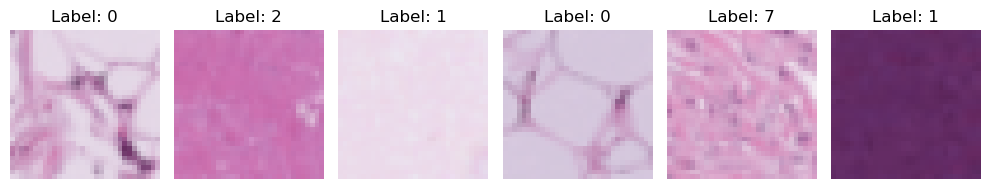

In [3]:
# Visualize a few images from the training set
images, labels = next(iter(train_loader))   # get one batch from the DataLoader

plt.figure(figsize=(10, 3))
for i in range(6):
    img = images[i].permute(1, 2, 0)        # convert from [C,H,W] to [H,W,C] for matplotlib
    img = img * 0.5 + 0.5                   # rescale from [-1,1] back to [0,1] for proper visualization
    plt.subplot(1, 6, i+1)
    plt.imshow(img)
    plt.title(f"Label: {labels[i].item()}") # numeric label
    plt.axis("off")

plt.tight_layout()
plt.show()

## 2. Definition of the CNN

With tabular data, we only used `Linear` layers.  
In contrast, for images, layers that respect the **spatial structure** are required:

- **`nn.Conv2d`**: convolutions that capture local patterns (e.g., edges, textures, shapes).  
- **`nn.MaxPool2d`**: reduce height and width while retaining the most important features, making the model more efficient.  
- **`nn.Linear`**: fully connected at the end to combine all features and achieve classification.

#### Objective:
Classify **3×32×32 (RGB)** images into **9 fabric classes** (PathMNIST dataset).

#### Model Structure:

1. **Conv1:** `nn.Conv2d(3 → 16, kernel=3, padding=1)`
   - Input: 3×32×32  
   - Output: 16×32×32  
   - The padding=1 maintains the spatial dimension (because \(32 - 3 + 2 \times 1 + 1 = 32\)).

2. **Pool1:** `nn.MaxPool2d(2,2)`
   - Halves height and width → 16×16×16.

3. **Conv2:** `nn.Conv2d(16 → 32, kernel=3, padding=1)`
   - Maintains the dimension (same reason as above) → 32×16×16.

4. **Pool2:** `nn.MaxPool2d(2,2)`
   - Halves again → 32×8×8.

5. **Flatten:**  
   - Flatten everything into a vector →  
     \( 32 × 8 × 8 = 2048 \) values for each image.

6. **FC1:** `nn.Linear(2048 → 128)`  
   - Reduces dimensionality (intermediate layer).

7. **FC2:** `nn.Linear(128 → 9)`  
   - Final output: 9 classes → one number for each type of fabric.

#### How We Calculated the Dimensions

| Step       | Formula                               | Result       |
|------------|---------------------------------------|--------------|
| After Conv1| \( (32 - 3 + 2 \times 1)/1 + 1 = 32 \) | maintains 32×32 |
| After Pool1| \( 32 / 2 = 16 \)                     | halves to 16×16 |
| After Conv2| \( (16 - 3 + 2 \times 1)/1 + 1 = 16 \) | maintains 16×16 |
| After Pool2| \( 16 / 2 = 8 \)                      | halves to 8×8 |
| Flatten    | \( 32×8×8 = 2048 \)                  | input for the fully connected layer |

**In summary:**
- Each *convolution* (with padding=1) **maintains** the spatial dimensions.  
- Each *pooling* **halves** the height and width.  
- The number of **feature maps** increases (3 → 16 → 32).  
- In the end, we obtain **2048 values** per image, used by the dense layers for classification.

In [4]:
# Define a simple Convolutional Neural Network
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # 1. First convolutional layer
        # Input: 3 channels (RGB)
        # Output: 16 feature maps
        # Kernel 3×3 with padding=1 → preserves spatial dimensions (32×32)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        
        # Pooling 2×2 → halves height and width (32×32 → 16×16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 2. Second convolutional layer
        # Input: 16 maps → Output: 32 maps
        # Padding=1 → preserves dimension (16×16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        # After conv2 + pool → (32×8×8)
        
        # 3. Fully connected layers
        # Flatten → 32 * 8 * 8 = 2048 features per image
        self.fc1 = nn.Linear(32 * 8 * 8, 128)  # reduces dimensionality
        self.fc2 = nn.Linear(128, 9)           # 9 final classes (tissue types)
        
    def forward(self, x):
        # Input: [N, 3, 32, 32]
        x = self.pool(F.relu(self.conv1(x)))   # → [N, 16, 16, 16]
        x = self.pool(F.relu(self.conv2(x)))   # → [N, 32, 8, 8]
        x = torch.flatten(x, 1)                # → [N, 2048] 
        x = F.relu(self.fc1(x))                # → [N, 128]
        x = self.fc2(x)                        # → [N, 9]
        return x


# Create the model and print its architecture
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)


## 3. Loss Function and Optimizer

The loss functions do not change significantly compared to tabular data:  
they depend on the type of problem (regression or classification), not on the fact that we are using images.

- **Regression** → e.g., `MSELoss` (Mean Squared Error)  
- **Classification** → e.g., `CrossEntropyLoss`  
  combines in a single step **Softmax + log-loss**  
  it is the standard choice for multi-class problems (such as PathMNIST with 9 classes)

The **optimizer** remains the same as we have already used:  
- **Adam** (more robust than pure SGD, adaptive, fast to use in practice)

The main difference here is not in the loss or the optimizer, but in the **type of data** and the model used (Conv2D instead of just Linear).

In [5]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 4. Training Loop

The flow remains the same as we have already seen with tabular data:

1. **Forward pass** → calculation of the model output  
2. **Loss** → comparison of output vs true labels  
3. **Backward pass** → calculation of gradients  
4. **Update** → updating the weights with the optimizer  

Main difference: the shape of the data
- **Tabular** → 2D input `(n_samples, n_features)`  
- **Images** → 4D input `(batch_size, C, H, W)`  
  - `C` = number of channels (1 = grayscale, 3 = RGB)  
  - `H, W` = height and width of the image  

This extra dimension is already handled in the `Conv2d`, `MaxPool2d`, etc., layers, so the logic of the training loop does not change.

In [6]:
# Training loop
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).long()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 0.9639
Epoch 2/10, Loss: 0.6511
Epoch 3/10, Loss: 0.5331
Epoch 4/10, Loss: 0.4513
Epoch 5/10, Loss: 0.3866
Epoch 6/10, Loss: 0.3392
Epoch 7/10, Loss: 0.3028
Epoch 8/10, Loss: 0.2727
Epoch 9/10, Loss: 0.2517
Epoch 10/10, Loss: 0.2289


## 5. Evaluation on the Test Set

The evaluation flow is the same as that observed with the tabular data:

1. we set the model to `eval()` mode  
2. we disable gradients with `torch.no_grad()`  
3. we calculate the predictions on the test set  
4. we compare with the true labels to obtain the accuracy

In [7]:
# Evaluate the model on the test set
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).long()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test set accuracy: {100 * correct / total:.2f}%")

Test set accuracy: 71.81%


## 6. Conclusion

Compared to tabular data, working with images requires some specific considerations:

- **Data Shape**  
  - Tabular → 2D tensors `(n_samples, n_features)`  
  - Images → 4D tensors `(batch_size, C, H, W)`  
    - `C` = channels (1 = grayscale, 3 = RGB)  
    - `H, W` = height and width  

- **Specialized Layers**  
  - `Conv2d` → extraction of local patterns  
  - `MaxPool2d` → reduction of spatial dimensions while retaining the most important features  
  - `Linear` → final combination for classification  

- **Flattening the Feature Maps**  
  - Before the fully connected layers, we need to convert from 4D tensors to 2D  
  - In PyTorch, we do this with `torch.flatten(x, 1)`  
  
The training loop and the basic logic remain the same as for tabular data.  
The main differences lie in the **data representation** and the **specialized layers**.  
We have now seen the entire flow from raw images to class predictions.